# 1) Download required files 

In [1]:
!wget https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
from inferenceutils import *

--2021-02-17 11:30:59--  https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2219 (2.2K) [text/plain]
Saving to: ‘inferenceutils.py’

inferenceutils.py   100%[===================>]   2.17K  --.-KB/s    in 0.001s  

2021-02-17 11:30:59 (2.09 MB/s) - ‘inferenceutils.py’ saved [2219/2219]



# 2) Extract the saved model

In [3]:
%%bash
unzip saved_model_frcnn_v1.zip
mv content/inference_graph/saved_model/label_map.pbtxt ./
mkdir dataset
mv content/inference_graph/saved_model/test_labels.csv ./dataset/
mkdir dataset/images
mkdir dataset/images/test
cp content/inference_graph/saved_model/test/* ./dataset/images/test

Archive:  saved_model_frcnn_v1.zip
   creating: content/inference_graph/saved_model/
   creating: content/inference_graph/saved_model/assets/
   creating: content/inference_graph/saved_model/variables/
  inflating: content/inference_graph/saved_model/variables/variables.index  
  inflating: content/inference_graph/saved_model/variables/variables.data-00000-of-00001  
   creating: content/inference_graph/saved_model/test/
  inflating: content/inference_graph/saved_model/test/Invoice_156.jpg  
  inflating: content/inference_graph/saved_model/test/Invoice_126_affine_translation.jpg  
  inflating: content/inference_graph/saved_model/test/Invoice_115_gaussianblur.jpg  
  inflating: content/inference_graph/saved_model/test/Invoice_142_horizontallyflip.jpg  
  inflating: content/inference_graph/saved_model/test/Invoice_166_horizontallyflip.jpg  
  inflating: content/inference_graph/saved_model/test/Invoice_98_horizontallyflip.jpg  
  inflating: content/inference_graph/saved_model/test/Invoice

# 3) Recall model configurations

In [4]:
output_directory = 'inference_graph'
labelmap_path = 'label_map.pbtxt'

import tensorflow as tf
from object_detection.utils import label_map_util
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'content/{output_directory}/saved_model')

# 4) Select images to be tested

In [5]:
import pandas as pd
test = pd.read_csv('dataset/test_labels.csv')
#Getting 3 random images to test
images = list(test.sample(n=3)['filename'])
images

['Invoice_109.jpg',
 'Invoice_76_affine_translation.jpg',
 'Invoice_121_brightness.jpg']

# 5) Test the detection model

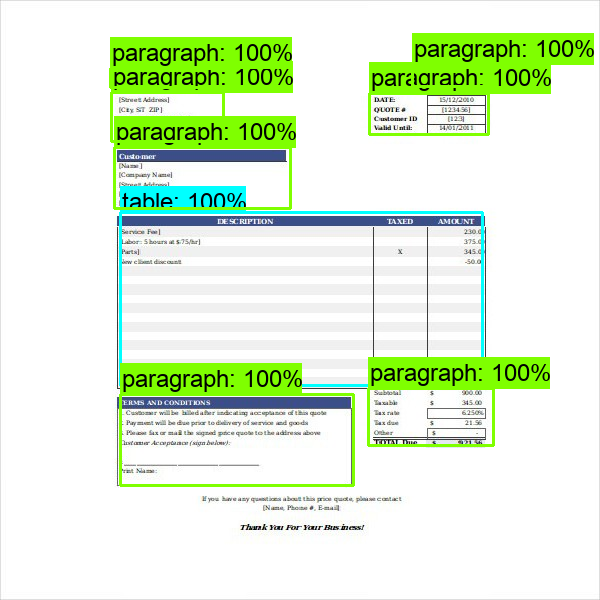

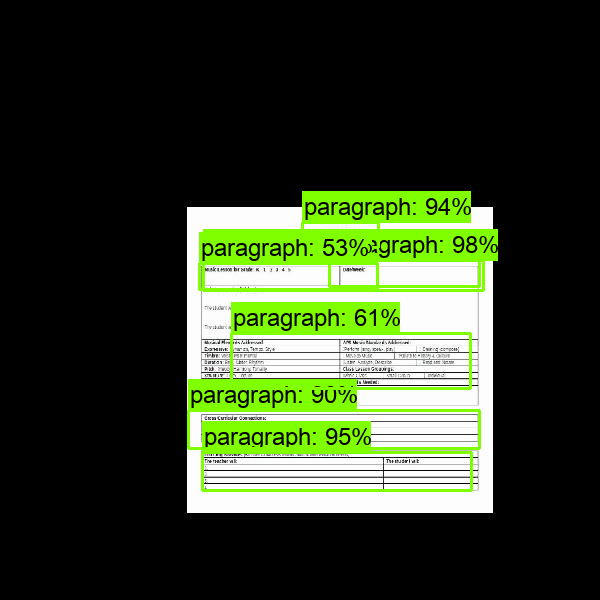

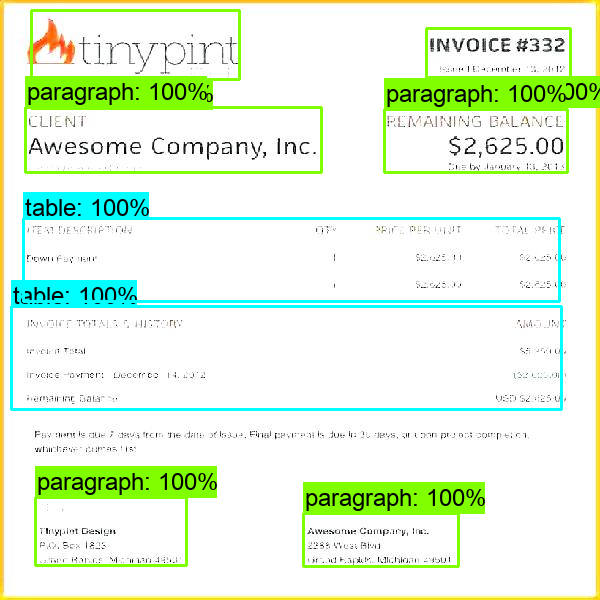

In [7]:
for image_name in images:
    image_np = load_image_into_numpy_array('dataset/images/test/' + image_name)
    output_dict = run_inference_for_single_image(model, image_np)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=3)
    display(Image.fromarray(image_np))

# 12) Export the predicted coordinates as CSV file

In [9]:
from tqdm import tqdm

rows = []

final_dataframe = pd.DataFrame(columns=['Image','Score','Class','Ymin','Xmin','Ymax','Xmax'])
for image_name in tqdm(images):
  
    image_np = load_image_into_numpy_array('dataset/images/test/' + image_name)
    output_dict = run_inference_for_single_image(model, image_np)

    # store boxes in dataframe!
    cut_off_scores = len(list(filter(lambda x: x >= 0.1, output_dict['detection_scores'])))

    for j in range(cut_off_scores):
        name = image_name
        scores = output_dict['detection_scores'][j]
        classes = output_dict['detection_classes'][j]
        for i in range(1,len(category_index)+1):
            if output_dict['detection_classes'][j] == category_index[i]['id']:
                classes = category_index[i]['name']
        ymin = output_dict['detection_boxes'][j][0]
        xmin = output_dict['detection_boxes'][j][1]
        ymax = output_dict['detection_boxes'][j][2]
        xmax = output_dict['detection_boxes'][j][3]

        row = list([name, scores, classes, ymin, xmin, ymax, xmax])
        rows.append(row)

final_df = pd.DataFrame(rows, columns = ['Image', 'Scores', 'Classes', 'ymin', 'xmin', 'ymax', 'xmax'])
final_df.to_csv('dataset/predicted_coordinates.csv', index = False)
final_df

100%|██████████| 3/3 [00:19<00:00,  6.45s/it]


,Image,Scores,Classes,ymin,xmin,ymax,xmax
0,Invoice_109.jpg,0.999929,table,0.353695,0.200344,0.643169,0.803348
1,Invoice_109.jpg,0.999788,paragraph,0.657102,0.201568,0.808992,0.588747
2,Invoice_109.jpg,0.999456,paragraph,0.245270,0.190509,0.347241,0.484129
3,Invoice_109.jpg,0.999396,paragraph,0.153666,0.186051,0.235724,0.372590
4,Invoice_109.jpg,0.998955,paragraph,0.156299,0.615530,0.223485,0.813645
5,Invoice_109.jpg,0.998945,paragraph,0.647352,0.614091,0.742574,0.823014
6,Invoice_109.jpg,0.998337,paragraph,0.108190,0.687395,0.143543,0.815649
7,Invoice_109.jpg,0.997693,paragraph,0.114961,0.184864,0.145683,0.367595
8,Invoice_109.jpg,0.371040,paragraph,0.820873,0.295708,0.887485,0.678089
9,Invoice_109.jpg,0.190263,paragraph,0.648290,0.234528,0.678141,0.584630
